In [24]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
from pulp import *
from scipy.optimize import linprog
#$soup = BeautifulSoup(open('chocolate_chip_cookies/recipe1.html', 'r'), 'html.parser')
from recipe_scrapers import scrape_me
from functools import reduce

In [4]:
scraper = scrape_me('https://www.allrecipes.com/recipe/25037/best-big-fat-chewy-chocolate-chip-cookie/')
ingredient_string = scraper.ingredients()
quantities = [float(i.split()[0]) for i in ingredient_string]
units = [i.split()[1] for i in ingredient_string]
ingredients = [" ".join(i.split()[2:]) for i in ingredient_string]
ingredients

for i in range(len(units)):
    if units[i] == 'egg':
        units[i] = "units"
        ingredients[i] = "egg" + ingredients[i]
    if units[i] == 'eggs':
        units[i] = "units"
        ingredients[i] = "egg" + ingredients[i]


In [5]:
scraper.cook_time()
scraper.instructions_list()

['Preheat the oven to 325 degrees F (165 degrees C). Grease cookie sheets or line with parchment paper.',
 'Sift together the flour, baking soda and salt; set aside.',
 'In a medium bowl, cream together the melted butter, brown sugar and white sugar until well blended. Beat in the vanilla, egg, and egg yolk until light and creamy. Mix in the sifted ingredients until just blended. Stir in the chocolate chips by hand using a wooden spoon. Drop cookie dough 1/4 cup at a time onto the prepared cookie sheets. Cookies should be about 3 inches apart.',
 'Bake for 15 to 17 minutes in the preheated oven, or until the edges are lightly toasted. Cool on baking sheets for a few minutes before transferring to wire racks to cool completely.']

In [14]:
def getDfFromRecipe(scraper):
    ingredient_string = scraper.ingredients()
    quantities = [float(i.split()[0]) for i in ingredient_string]
    units = [i.split()[1] for i in ingredient_string]
    ingredients = [" ".join(i.split()[2:]) for i in ingredient_string]
    ingredients
    
    for i in range(len(units)):
        if units[i] == 'egg':
            units[i] = "units"
            ingredients[i] = "egg" + ingredients[i]
        if units[i] == 'eggs':
            units[i] = "units"
            ingredients[i] = "egg" + ingredients[i]
        if units[i] == 'large':
            units[i] = "units"
            ingredients[i] = "egg"

    df = pd.DataFrame({'quantities' : quantities, "units" : units, "ingredients" : ingredients})
    
    # delete weird ingredients
    df = df[df.ingredients != "white chocolate chips"]
    df = df[df.ingredients != "chopped walnuts"]
    
    # chocolate chip conversion
    df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
    df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
    df['ingredients'][["chocolate chips" in i for i in df.ingredients]] = "chocolate chips"
    
    # butter conversion
    df['ingredients'][["butter" in i for i in df.ingredients]] = "butter"
    df['ingredients'][["brown sugar" in i for i in df.ingredients]] = "brown sugar"
    df['ingredients'][["vanilla extract" in i for i in df.ingredients]] = "vanilla extract"
    df['ingredients'][["granulated sugar" in i for i in df.ingredients]] = "white sugar"
    df['ingredients'][["flour" in i for i in df.ingredients]] = "all-purpose flour"
    
    print(df)

    densities = {'all-purpose flour' : 0.763,
                'baking soda' : 2.2,
                'salt' : 2.16,
                'butter' : 0.96,
                 'butter, softened': 0.96,
                'white sugar' : 0.85,
                'vanilla extract' : 0.88,
                'chocolate chips' : 1.01,
                'eggs' : 1.031,
                'egg' : 1.031,
                 'eggyolk' : 1.023,
                'brown sugar': 0.93,
                'hot water' : 1} # g/cc
    
#volumnes in cm^3
    volumes = {'cups' : 236.588,
               'cup' : 236.588,
              "teaspoon" : 4.92892,
               "teaspoons" : 4.92892,
               "tablespoon" : 14.7868,
               "tablespoons" : 14.7868,
              "units" : 44.3604, # units refers to eggs, which are on average 3 tbs and 44.3 cubic centimeters
              "(12": 354.882} 

    df = df[[i in densities.keys() for i in df.ingredients]]
    
    df["densities (g/cm3)"] = [densities[i] for i in df.ingredients]
    df["volumes (cm3/unit)"] = [volumes[i] for i in df.units]
    df["weight (g)"] = df["quantities"] * df["densities (g/cm3)"] * df["volumes (cm3/unit)"]
    norm = df["weight (g)"][df.ingredients == "all-purpose flour"]
    print(norm)
    df["weight normalized (g)"] = df["weight (g)"].div(float(norm))
    df = df.sort_values('ingredients')
    df = df.loc[:, ["ingredients", "weight normalized (g)"]]
    return(df)

In [19]:
recipe_urls = ["https://www.allrecipes.com/recipe/22848/ashleys-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/284215/soft-and-chewy-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/130736/ultimate-high-altitude-chocolate-chip-cookies/",
              #"https://www.allrecipes.com/recipe/255339/vanilla-rich-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/244631/chef-johns-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/25038/chewy-jumbo-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/25040/chocolate-chip-cookies-v/",
              "https://www.allrecipes.com/recipe/19191/giant-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/17209/absolutely-the-best-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/10711/soft-chocolate-chip-cookies-ii/",
              "https://www.allrecipes.com/recipe/10813/best-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/25037/best-big-fat-chewy-chocolate-chip-cookie/",
              "https://www.allrecipes.com/recipe/15004/award-winning-soft-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/10141/outrageous-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/17209/absolutely-the-best-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/15300/tinas-shortbread-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/15475/stephens-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/15462/neiman-marcus-chocolate-chip-cookie/",
              "https://www.allrecipes.com/recipe/25046/best-ever-chocolate-chip-cookies-iii/",
              "https://www.allrecipes.com/recipe/11195/angel-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/25027/chocolate-chip-cookies-vii/",
              "https://www.allrecipes.com/recipe/15004/award-winning-soft-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/25027/chocolate-chip-cookies-vii/",
              "https://www.allrecipes.com/recipe/25040/chocolate-chip-cookies-v/",
              "https://www.allrecipes.com/recipe/10141/outrageous-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/15475/stephens-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/10050/zippy-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/9928/hillary-clintons-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/10331/moms-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/25038/chewy-jumbo-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/19191/giant-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/17209/absolutely-the-best-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/10032/allisons-supreme-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/255339/vanilla-rich-chocolate-chip-cookies/",
              "https://www.allrecipes.com/recipe/24423/easy-chocolate-chip-cookies/"]
              #"https://www.allrecipes.com/recipe/244643/super-easy-chocolate-chip-cookies/",
              #"https://www.allrecipes.com/recipe/10711/soft-chocolate-chip-cookies-ii/"]
              #"https://www.allrecipes.com/recipe/24423/easy-chocolate-chip-cookies/",""]

recipe_urls = set(recipe_urls)
recipe_urls = list(recipe_urls)
recipes = list()
for i in range(len(recipe_urls)):
    print(i)
    print(recipe_urls[i])
    recipes.append(getDfFromRecipe(scrape_me(recipe_urls[i])))

#recipe1 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/25046/best-ever-chocolate-chip-cookies-iii/'))
#recipe2 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/10813/best-chocolate-chip-cookies/'))
#recipe3 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/25037/best-big-fat-chewy-chocolate-chip-cookie/'))
#recipe4 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/15004/award-winning-soft-chocolate-chip-cookies/'))
#recipe5 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/10141/outrageous-chocolate-chip-cookies/'))
#recipe6 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/17209/absolutely-the-best-chocolate-chip-cookies/'))
#recipe7 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/15300/tinas-shortbread-chocolate-chip-cookies/'))
#recipe8 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/15475/stephens-chocolate-chip-cookies/'))
#recipe9 = getDfFromRecipe(scrape_me('https://www.allrecipes.com/recipe/15462/neiman-marcus-chocolate-chip-cookie/'))


0
https://www.allrecipes.com/recipe/10331/moms-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

   quantities     units                                 ingredients
0        1.00       cup                                      butter
1        0.75       cup                                 brown sugar
2        0.25       cup                                 white sugar
3        1.00      (3.5  ounce) package instant vanilla pudding mix
4        2.00     units                                         egg
5        1.00  teaspoon                             vanilla extract
6        2.25      cups                           all-purpose flour
7        1.00  teaspoon                                 baking soda
8        2.00      cups                             chocolate chips
6    406.162449
Name: weight (g), dtype: float64
1
https://www.allrecipes.com/recipe/15462/neiman-marcus-chocolate-chip-cookie/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

    quantities        units                     ingredients
0         0.50          cup                          butter
1         1.00          cup                     brown sugar
2         3.00  tablespoons                     white sugar
3         1.00        units                             egg
4         2.00    teaspoons                 vanilla extract
5         1.75         cups               all-purpose flour
6         0.50     teaspoon                     baking soda
7         0.50     teaspoon                   baking powder
8         0.50     teaspoon                            salt
9         1.50    teaspoons  instant espresso coffee powder
10        1.50         cups                 chocolate chips
5    315.904127
Name: weight (g), dtype: float64
2
https://www.allrecipes.com/recipe/10711/soft-chocolate-chip-cookies-ii/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

   quantities     units        ingredients
0        0.50       cup             butter
1        0.50       cup         shortening
2        0.75       cup        brown sugar
3        0.50       cup        white sugar
4        1.00     units                egg
5        1.00  teaspoon    vanilla extract
6        1.00  teaspoon        baking soda
7        0.25  teaspoon               salt
8        1.50      cups    chocolate chips
9        2.00      cups  all-purpose flour
9    361.033288
Name: weight (g), dtype: float64
3
https://www.allrecipes.com/recipe/255339/vanilla-rich-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["chocolate chips" in i for i in df.ingredients]] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["

   quantities      units                      ingredients
0    3.250000       cups                all-purpose flour
1    1.000000   teaspoon                      baking soda
2    0.750000   teaspoon                             salt
3    1.333333       cups                           butter
4    1.250000       cups                      white sugar
5    1.000000        cup                      brown sugar
6    2.000000      units                              egg
7    4.000000  teaspoons  McCormick® Pure Vanilla Extract
8    1.000000        (12                  chocolate chips
0    586.679093
Name: weight (g), dtype: float64
4
https://www.allrecipes.com/recipe/9928/hillary-clintons-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

   quantities     units        ingredients
0         1.5      cups  all-purpose flour
1         1.0  teaspoon               salt
2         1.0  teaspoon        baking soda
3         1.0       cup         shortening
4         1.0       cup        brown sugar
5         0.5       cup        white sugar
6         1.0  teaspoon    vanilla extract
7         2.0     units                egg
8         2.0      cups        rolled oats
9         2.0      cups    chocolate chips
0    270.774966
Name: weight (g), dtype: float64
5
https://www.allrecipes.com/recipe/10141/outrageous-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

    quantities     units        ingredients
0     0.500000       cup             butter
1     0.500000       cup        white sugar
2     0.333333       cup        brown sugar
3     0.500000       cup             butter
4     0.500000  teaspoon    vanilla extract
5     1.000000     units                egg
6     1.000000       cup  all-purpose flour
7     1.000000  teaspoon        baking soda
8     0.250000  teaspoon               salt
9     0.500000       cup        rolled oats
10    1.000000       cup    chocolate chips
6    180.516644
Name: weight (g), dtype: float64
6
https://www.allrecipes.com/recipe/22848/ashleys-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

   quantities     units        ingredients
0    1.666667      cups  all-purpose flour
1    0.750000  teaspoon      baking powder
2    0.500000  teaspoon        baking soda
3    0.500000  teaspoon               salt
4    0.750000       cup             butter
5    0.750000       cup        brown sugar
6    0.333333       cup        white sugar
7    1.000000     units                egg
8    1.000000  teaspoon    vanilla extract
9    2.000000      cups    chocolate chips
0    300.861088
Name: weight (g), dtype: float64
7
https://www.allrecipes.com/recipe/130736/ultimate-high-altitude-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

   quantities     units        ingredients
0         1.0       cup             butter
1         1.0       cup        white sugar
2         1.0       cup        brown sugar
3         3.0     units                egg
4         1.0  teaspoon    vanilla extract
5         0.5  teaspoon               salt
6         1.0  teaspoon        baking soda
7         3.5      cups  all-purpose flour
8         1.0       cup    chocolate chips
7    631.808254
Name: weight (g), dtype: float64
8
https://www.allrecipes.com/recipe/15300/tinas-shortbread-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["chocolate chips" in i for i in df.ingredients]] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["

   quantities     units        ingredients
0        1.75      cups  all-purpose flour
1        0.50  teaspoon      baking powder
2        0.25  teaspoon               salt
3        1.00       cup             butter
4        0.50       cup        white sugar
5        0.75       cup    chocolate chips
0    315.904127
Name: weight (g), dtype: float64
9
https://www.allrecipes.com/recipe/25040/chocolate-chip-cookies-v/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

   quantities      units                                        ingredients
0        2.25       cups                                  all-purpose flour
1        1.00   teaspoon                                        baking soda
2        1.00   teaspoon                                               salt
3        1.00       (3.3  ounce) package instant white chocolate pudding...
4        1.00        cup                                             butter
5        1.00        cup                                        white sugar
6        0.75        cup                                        brown sugar
7        2.00      units                                                egg
8        2.00  teaspoons                                    vanilla extract
9        2.00       cups                                    chocolate chips
0    406.162449
Name: weight (g), dtype: float64
10
https://www.allrecipes.com/recipe/11195/angel-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

   quantities      units        ingredients
0         1.0        cup         shortening
1         2.0       cups        white sugar
2         4.0      units                egg
3         2.0  teaspoons    vanilla extract
4         6.0       cups  all-purpose flour
5         2.0  teaspoons      baking powder
6         2.0  teaspoons        baking soda
7         2.0  teaspoons    cream of tartar
8         2.0       cups               milk
9         2.0       cups    chocolate chips
4    1083.099864
Name: weight (g), dtype: float64
11
https://www.allrecipes.com/recipe/10032/allisons-supreme-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["chocolate chips" in i for i in df.ingredients]] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["

    quantities       units              ingredients
0         0.50         cup               shortening
1         0.50         cup                   butter
2         0.75         cup              brown sugar
3         0.75         cup              white sugar
4         2.00       units                      egg
5         1.00    teaspoon          vanilla extract
6         1.00  tablespoon  coffee-flavored liqueur
7         2.00        cups        all-purpose flour
8         1.00    teaspoon              baking soda
9         1.00    teaspoon                     salt
10        2.00        cups              rolled oats
11        2.00        cups          chocolate chips
7    361.033288
Name: weight (g), dtype: float64
12
https://www.allrecipes.com/recipe/244631/chef-johns-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "jumbo semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients']

   quantities        units        ingredients
0        2.25         cups  all-purpose flour
1        1.25    teaspoons        kosher salt
2        1.00     teaspoon        baking soda
3        1.00          cup             butter
4        1.00          cup        white sugar
5        0.50          cup        brown sugar
6        1.00        units                egg
7        2.00  tablespoons               milk
8        1.25    teaspoons    vanilla extract
9        2.00         cups    chocolate chips
0    406.162449
Name: weight (g), dtype: float64
13
https://www.allrecipes.com/recipe/15004/award-winning-soft-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["chocolate chips" in i for i in df.ingredients]] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["

   quantities      units                                  ingredients
0         4.5       cups                            all-purpose flour
1         2.0  teaspoons                                  baking soda
2         2.0       cups                                       butter
3         1.5       cups                                  brown sugar
4         0.5        cup                                  white sugar
5         2.0       (3.4  ounce) packages instant vanilla pudding mix
6         4.0      units                                          egg
7         2.0  teaspoons                              vanilla extract
8         4.0       cups                              chocolate chips
0    812.324898
Name: weight (g), dtype: float64
14
https://www.allrecipes.com/recipe/10050/zippy-chocolate-chip-cookies/


<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["chocolate chips" in i for i in df.ingredients]] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["

   quantities       units          ingredients
0        1.00         cup               butter
1        1.00         cup          brown sugar
2        0.75         cup          white sugar
3        2.00       units                  egg
4        1.00  tablespoon      vanilla extract
5        2.50        cups    all-purpose flour
6        0.50    teaspoon        baking powder
7        0.50    teaspoon          baking soda
8        1.00    teaspoon  ground white pepper
9        3.00        cups      chocolate chips
5    451.29161
Name: weight (g), dtype: float64
15
https://www.allrecipes.com/recipe/25038/chewy-jumbo-chocolate-chip-cookies/
   quantities       units        ingredients
0        3.50        cups  all-purpose flour
1        1.00         cup  all-purpose flour
2        1.00    teaspoon      baking powder
3        1.00    teaspoon        baking soda
4        1.50        cups             butter
5        1.25        cups        white sugar
6        1.25        cups        brown su

<ipython-input-14-49e1bb37a96d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][df.ingredients == "semisweet chocolate chips"] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["chocolate chips" in i for i in df.ingredients]] = "chocolate chips"
<ipython-input-14-49e1bb37a96d>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ingredients'][["

TypeError: cannot convert the series to <class 'float'>

In [25]:
df_merge = reduce(lambda left, right:     # Merge DataFrames in list
                     pd.merge(left , right,
                              on = ["ingredients"],
                              how = "outer"),
                     recipes)

df_merge = df_merge.transpose()
df_merge = df_merge.rename(columns = df_merge.loc['ingredients'])
df_merge = df_merge.drop('ingredients')

df_final = df_merge.loc[:,~df_merge.columns.duplicated()].copy()
print(df_final.shape)
print(len(recipe_urls))
df_final

(15, 9)
25


<ipython-input-25-96190f8cd167>:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'weight normalized (g)_x'} in the result is deprecated and will raise a MergeError in a future version.
  pd.merge(left , right,


all-purpose flour baking soda brown sugar    butter  \
weight normalized (g)_x               1.0    0.026698    0.406291  0.559196   
weight normalized (g)_y               1.0    0.017163    0.696499  0.359483   
weight normalized (g)_x               1.0    0.030035    0.457077  0.314548   
weight normalized (g)_y               1.0    0.018483    0.375038  0.516181   
weight normalized (g)_x               1.0    0.040047    0.812582       NaN   
weight normalized (g)_y               1.0     0.06007    0.406291  0.629096   
weight normalized (g)_x               1.0    0.018021    0.548493  0.566186   
weight normalized (g)_y               1.0    0.017163    0.348249  0.359483   
weight normalized (g)_x               1.0         NaN         NaN  0.718966   
weight normalized (g)_y               1.0    0.026698    0.406291  0.559196   
weight normalized (g)_x               1.0    0.020023         NaN       NaN   
weight normalized (g)_y               1.0    0.030035    0.457077  0.314548   
weight normalized (g)_x               1.0    0.026698    0.270861  0.559196   
weight normalized (g)_y               1.0    0.026698    0.406291  0.559196   
weight normalized (g)                 1.0    0.012014    0.487549  0.503277   

                        chocolate chips       egg vanilla extract white sugar  \
weight normalized (g)_x        1.176642  0.225208        0.010679     0.12378   
weight normalized (g)_y        1.134619  0.144777        0.027461     0.11936   
weight normalized (g)_x        0.992792   0.12668        0.012014    0.278506   
weight normalized (g)_y        0.610949  0.155913             NaN    0.428471   
weight normalized (g)_x        1.764963  0.337812        0.016019    0.371341   
weight normalized (g)_y        1.323722  0.253359        0.012014    0.557012   
weight normalized (g)_x        1.588467  0.152016        0.014417    0.222805   
weight normalized (g)_y        0.378206  0.217165        0.006865    0.318292   
weight normalized (g)_x        0.567309       NaN             NaN    0.318292   
weight normalized (g)_y        1.176642  0.225208        0.021358    0.495122   
weight normalized (g)_x        0.441241  0.168906        0.008009    0.371341   
weight normalized (g)_y        1.323722  0.253359        0.012014    0.417759   
weight normalized (g)_x        1.176642  0.112604        0.013349    0.495122   
weight normalized (g)_y        1.176642  0.225208        0.010679     0.12378   
weight normalized (g)          1.588467  0.202687        0.028834    0.334207   

                             salt  
weight normalized (g)_x       NaN  
weight normalized (g)_y  0.016851  
weight normalized (g)_x  0.007372  
weight normalized (g)_y   0.01361  
weight normalized (g)_x  0.039319  
weight normalized (g)_y  0.014744  
weight normalized (g)_x  0.017693  
weight normalized (g)_y  0.008425  
weight normalized (g)_x  0.008425  
weight normalized (g)_y  0.026212  
weight normalized (g)_x       NaN  
weight normalized (g)_y  0.029489  
weight normalized (g)_x       NaN  
weight normalized (g)_y       NaN  
weight normalized (g)         NaN

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


In [27]:
df_final.columns.values[df_final.columns.values == "chocolate chips"] = "chocolate \n chips"
df_final.columns.values[df_final.columns.values == "vanilla extract"] = "vanilla \n extract"
df_final.columns.values

array(['all-purpose flour', 'baking soda', 'brown sugar', 'butter',
       'chocolate \n chips', 'egg', 'vanilla \n extract', 'white sugar',
       'salt'], dtype=object)

C:\Users\kitikomp\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


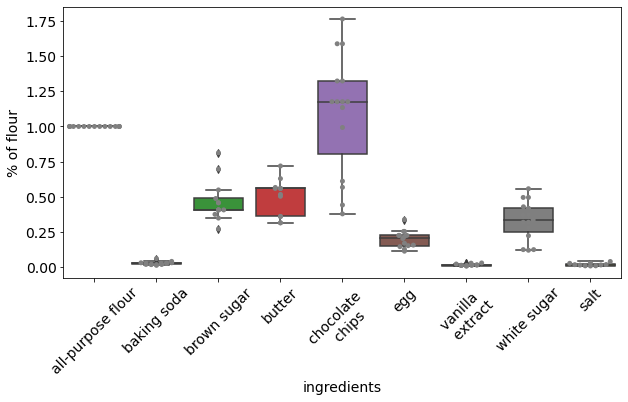

In [28]:
df_melt = df_final.melt()
sns.boxplot(data = df_melt, x = "variable", y = "value")
sns.swarmplot(data = df_melt, x = "variable", y = "value", color= "grey")
plt.xticks(rotation=45)
plt.ylabel("% of flour", fontsize = 14)
plt.xlabel("ingredients", fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=14)

In [32]:
df_final.mean(axis = 0)*250

all-purpose flour     250.000000
baking soda             6.604367
brown sugar           116.895941
butter                125.356782
chocolate \n chips    273.683728
egg                    50.016146
vanilla \n extract      3.725218
white sugar            82.919839
salt                    4.553538
dtype: float64